<a href="https://colab.research.google.com/github/noahruiz416/UFC-Fight-Prediction-Application-Model/blob/main/Notebooks/catBoostRegFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# dependencies 
!pip install catboost 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [9]:
import pandas as pd 
from catboost import CatBoostClassifier

In [34]:
#this function will allows us to calculate important model metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def metric_scoring(classifier, x_test_data, y_test_data, model_name):
  y_true = y_test_data
  y_pred = classifier.predict(x_test_data)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  metric_data = {
    'Model Name': model_name,
    'Precision' : round(precision,4),
    'Recall' : round(recall,4),
    'Accuracy': round(accuracy,4),
    'F1 Score': round(f1,4)
  }
  return metric_data

In [37]:
from sklearn import preprocessing

#loading our processed training data
x_train = pd.read_csv("X_processed_train.csv", index_col = 0)
y_train = pd.read_csv("y_processed_train.csv", index_col = 0)

y_train = preprocessing.LabelBinarizer().fit_transform(y_train['Winner'])

In [224]:
#first lets try our catboost model but drop fighter names, to see how it effects performance and specifically feature selection
x_train_no_name = x_train.drop(columns = ['R_fighter', 'B_fighter'])

In [39]:
categorical_features_indices = ["Referee", "location", "weight_class", "B_Stance", "R_Stance"]
model = CatBoostClassifier(cat_features = categorical_features_indices)

In [ ]:
model.fit(x_train_no_name, y_train)

In [225]:
#with our model fit we will now load and prep our train data and evalutae model performance 
x_processed_test = pd.read_csv('X_processed_test.csv', index_col = 0)
y_processed_test = pd.read_csv('y_processed_test.csv', index_col = 0)
y_processed_test = preprocessing.LabelBinarizer().fit_transform(y_processed_test['Winner'])

#dropping names
x_test_no_name = x_processed_test.drop(columns = ['R_fighter', 'B_fighter'])

In [43]:
#model performance does take a little hit from taking out names, however our model should become much more interpretable
metric_scoring(model, x_test_no_name, y_processed_test, 'CatBoost No Names')

{'Accuracy': 0.6747,
 'F1 Score': 0.7786,
 'Model Name': 'CatBoost No Names',
 'Precision': 0.7028,
 'Recall': 0.8729}

In [ ]:
!pip install shap

In [62]:
import shap

In [74]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test_no_name)

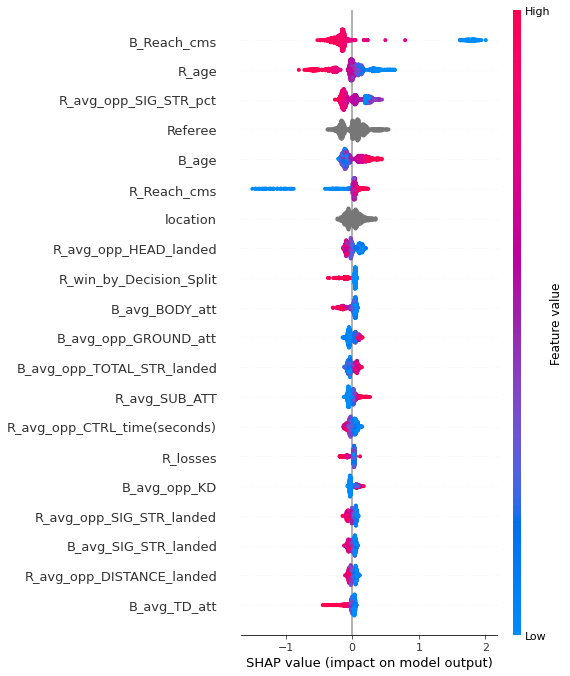

In [75]:
shap.summary_plot(shap_values, x_test_no_name)

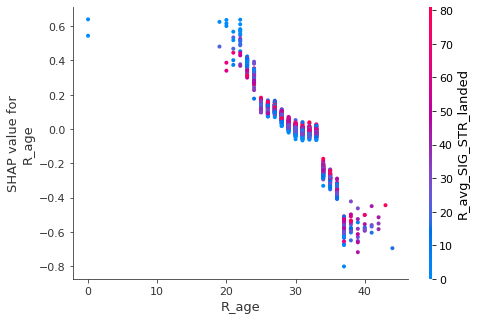

In [76]:
shap.dependence_plot("R_age", shap_values, x_test_no_name)

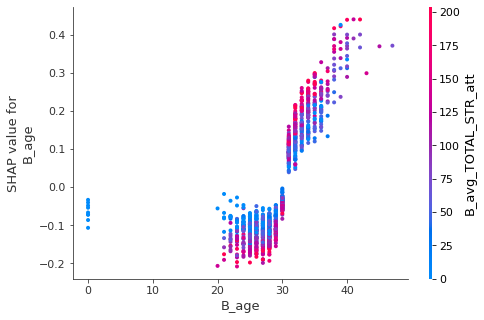

In [77]:
shap.dependence_plot("B_age", shap_values, x_test_no_name)

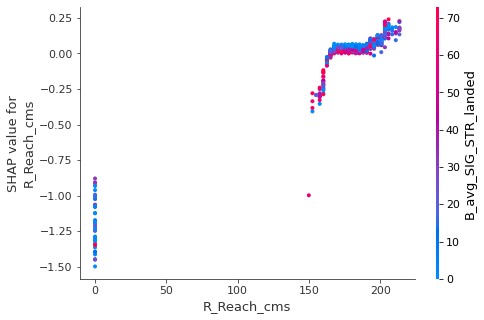

In [78]:
shap.dependence_plot("R_Reach_cms", shap_values, x_test_no_name)

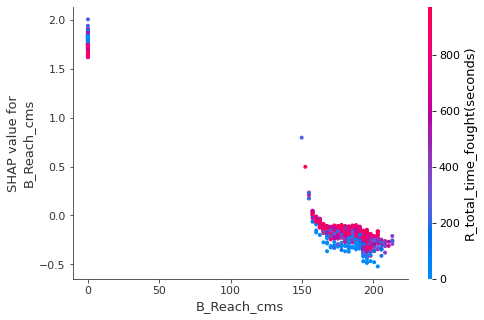

In [79]:
shap.dependence_plot("B_Reach_cms", shap_values, x_test_no_name)

In [149]:
#now we will try and model with dropped na values 
#this assumption makes sense as there are many old fights where null values where common
x_train_df_2 = pd.read_csv("X_train_data.csv", index_col = 0)
y_train_df_2 = pd.read_csv("y_train_data.csv", index_col = 0)

In [ ]:
#creating a distirbution of missing data
null_vals = (x_train_df_2[x_train_df_2.isnull().any(axis=1)])
null_vals['date'] = pd.to_datetime(null_vals['date'])
null_vals['year'] = null_vals['date'].dt.year

In [ ]:
#good amount of missing data for the later year skewed dist 
null_vals['year'].hist()

In [151]:
#joining frames together to get rid of nulls
x_all = x_train_df_2.join(y_train_df_2).dropna()

#getting seperate frames
x_train_df_2 = x_all.drop(columns = ['R_fighter', 'B_fighter', 'Winner', 'date']).dropna()
y_train_df_2 = x_all['Winner']

#binarizing labels
y_train_df_2 = preprocessing.LabelBinarizer().fit_transform(y_train_df_2)

In [152]:
x_train_df_2 = x_all.drop(columns = ['R_fighter', 'B_fighter', 'Winner', 'date']).dropna()
y_train_df_2 = x_all['Winner']

In [154]:
categorical_features_indices = ["Referee", "location", "weight_class", "B_Stance", "R_Stance"]
model_na = CatBoostClassifier(cat_features = categorical_features_indices)

In [ ]:
model_na.fit(x_train_df_2, y_train_df_2)

In [157]:
#prepping test data 
x_test_df_2 = pd.read_csv("X_test_data.csv", index_col = 0)
y_test_df_2 = pd.read_csv("y_test_data.csv", index_col = 0)

#joining frames together to get rid of nulls
x_test_all = x_test_df_2.join(y_test_df_2).dropna()

#getting seperate frames
x_test_df_2 = x_test_all.drop(columns = ['R_fighter', 'B_fighter', 'Winner', 'date']).dropna()
y_test_df_2 = x_test_all['Winner']

#binarizing labels
y_test_df_2 = preprocessing.LabelBinarizer().fit_transform(y_test_df_2)


In [158]:
#null values assumption causes model to perform much worse than before
metric_scoring(model_na, x_test_df_2, y_test_df_2, 'CatBoost with Nulls')

{'Accuracy': 0.6339,
 'F1 Score': 0.7379,
 'Model Name': 'CatBoost with Nulls',
 'Precision': 0.6686,
 'Recall': 0.8231}

In [230]:
#x_train_no_name.drop(columns = 'Referee', inplace = True)
categorical_features_indices2 = ["weight_class", "B_Stance", "R_Stance"]


In [233]:
model3 = CatBoostClassifier(cat_features = categorical_features_indices2)

model3.select_features(X = x_train_no_name.drop(columns = ['Referee', 'location']), y = y_train, features_for_select = x_train_no_name.drop(columns = ['Referee', 'location']).columns, num_features_to_select= 5)

Learning rate set to 0.020432
Step #1 out of 1
0:	learn: 0.6888892	total: 95.8ms	remaining: 1m 35s
1:	learn: 0.6848008	total: 182ms	remaining: 1m 30s
2:	learn: 0.6815015	total: 262ms	remaining: 1m 27s
3:	learn: 0.6779119	total: 339ms	remaining: 1m 24s
4:	learn: 0.6743440	total: 435ms	remaining: 1m 26s
5:	learn: 0.6703279	total: 507ms	remaining: 1m 23s
6:	learn: 0.6673567	total: 565ms	remaining: 1m 20s
7:	learn: 0.6651279	total: 618ms	remaining: 1m 16s
8:	learn: 0.6619877	total: 688ms	remaining: 1m 15s
9:	learn: 0.6590191	total: 751ms	remaining: 1m 14s
10:	learn: 0.6569757	total: 814ms	remaining: 1m 13s
11:	learn: 0.6549131	total: 875ms	remaining: 1m 12s
12:	learn: 0.6521246	total: 963ms	remaining: 1m 13s
13:	learn: 0.6495609	total: 1.04s	remaining: 1m 12s
14:	learn: 0.6473146	total: 1.14s	remaining: 1m 14s
15:	learn: 0.6457679	total: 1.21s	remaining: 1m 14s
16:	learn: 0.6441081	total: 1.28s	remaining: 1m 13s
17:	learn: 0.6419748	total: 1.33s	remaining: 1m 12s
18:	learn: 0.6398303	total

{'eliminated_features': [58,
  125,
  131,
  59,
  126,
  64,
  60,
  65,
  61,
  54,
  129,
  128,
  53,
  66,
  62,
  81,
  0,
  57,
  18,
  121,
  14,
  63,
  83,
  103,
  24,
  118,
  55,
  93,
  16,
  91,
  15,
  79,
  119,
  12,
  5,
  27,
  56,
  123,
  39,
  10,
  41,
  2,
  105,
  26,
  34,
  117,
  51,
  85,
  38,
  132,
  31,
  122,
  104,
  68,
  84,
  47,
  78,
  35,
  96,
  52,
  113,
  36,
  42,
  82,
  8,
  133,
  90,
  40,
  50,
  1,
  33,
  114,
  109,
  77,
  80,
  110,
  74,
  44,
  120,
  98,
  124,
  11,
  130,
  135,
  108,
  49,
  30,
  76,
  106,
  102,
  6,
  45,
  22,
  43,
  13,
  17,
  9,
  70,
  112,
  86,
  69,
  3,
  32,
  88,
  21,
  92,
  25,
  111,
  89,
  99,
  115,
  37,
  7,
  101,
  107,
  4,
  87,
  71,
  48,
  29,
  19,
  100,
  97,
  23,
  95,
  73,
  116,
  75,
  127,
  46,
  20,
  28,
  94],
 'eliminated_features_names': ['B_draw',
  'R_draw',
  'R_win_by_TKO_Doctor_Stoppage',
  'B_win_by_Decision_Majority',
  'R_win_by_Decision_Majority',
  

In [234]:
metric_scoring(model3, x_test_no_name.drop(columns = ['Referee', 'location']), y_processed_test, 'CatBoost No Names Regularized')

{'Accuracy': 0.653,
 'F1 Score': 0.7653,
 'Model Name': 'CatBoost No Names Regularized',
 'Precision': 0.6874,
 'Recall': 0.8631}

In [235]:
explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(x_test_no_name.drop(columns = ['Referee', 'location']))

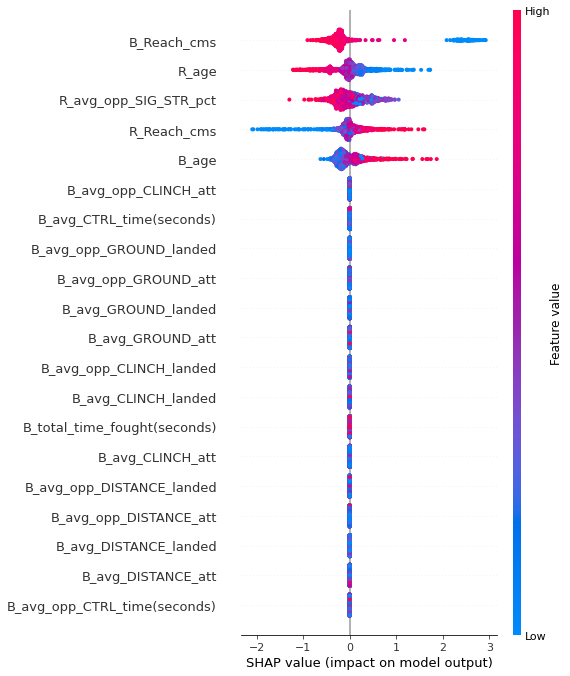

In [236]:
shap.summary_plot(shap_values, x_test_no_name.drop(columns = ['Referee', 'location']))